In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import dblquad
import time

from math import *
import scipy.stats
from pandas import *
from scipy.integrate import quad
import seaborn as sns
import scipy as s
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go
from scipy import linalg
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rc
from concurrent.futures import ProcessPoolExecutor

DTYPE='float32'

In [ ]:
# The below is to load the Fredholm NN classes - Adjust according to your folder architecture/path where the fredholm_nn_models.py has been saved

from google.colab import drive
drive.mount('/content/drive')

FOLDER = "/content/drive/MyDrive/Fredholm_Neural_Networks/Github/Python"

import sys, os, importlib
if FOLDER not in sys.path:
    sys.path.insert(0, FOLDER)

# print("CWD:", os.getcwd())
# print("Folder exists?", os.path.isdir(FOLDER))
# print("Files:", os.listdir(FOLDER)[:10])


from potential_fredholm_nn_models import FredholmNeuralNetwork_Poisson, PotentialFredholmNeuralNetwork_Poisson


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions and definitions used for the the Potential Fredholm Neural Network solution to the Poisson PDE.

We consider the two-dimensional linear Poisson equation for $u(x)$:

  \begin{equation}
        \begin{cases}\Delta u(x) = \psi(x), & \text { for } x \in \Omega \\ u(x)= f(x) & \text { for } {x} \in \partial \Omega. \end{cases}
    \end{equation}




The Poisson PDE can be solved using a Fredholm NN, with $M+1$ hidden layers, where the weights and biases of the $M$ hidden layers are used iteratively solve the BIE (\ref{BIE}) on a discretized grid of the boundary, $y_1, \dots, y_N$,
for which the final and output weights $W_{M+1} \in \mathbb{R}^{N \times N}, W_O \in \mathbb{R}^N$ given by:
\begin{equation}
    W_{M+1}= I_{N \times N},
    \,\,\,\,\
    W_{O}= \left(\begin{array}{cccc}
	D \Phi({x}, {y}_1) \delta \sigma_{y}, & D \Phi({x}, {y}_2)\delta \sigma_{y}, & \dots, & {D} \Phi({x}, {y}_N) \delta \sigma_{y}
\end{array}\right)^{\top},
\end{equation}
are used to define the simple operator ${D} \Phi({x}, {y}):= \Big(\frac{\partial \Phi}{\partial n_{y}}({x}, {y})- \frac{\partial \Phi}{\partial n_{y}}({x}^{\star}, {y})\Big)$. The corresponding biases $b_{M+1} \in \mathbb{R}^{N}$ and $b_O \in \mathbb{R}$ are given by:
\begin{equation}
   b_{M+1} = \left(\begin{array}{ccc}
		- \beta({x}^{\star}), \dots, - \beta({x}^{\star})
	\end{array}\right)^{\top}, \,\,\,\   b_O= \frac{1}{2} \beta({x}^{\star}) + \int_{\partial \Omega} \beta(y) \frac{\partial \Phi(x^*, y)}{\partial n_y} d\sigma_y + \int_{\Omega} \Phi({x},{y}) \psi(y) dy,
\end{equation}
where $x^*:= (1, \phi) \in \partial \Omega$ is the unique point on the boundary corresponding to $x:= (r, \phi) \in \Omega$.  


In [ ]:
"""
The code here is to be used for the term(s) required in the Fredholm Neural Network and Potential Fredholm Neural Network.
We want to calculatate the integral of fundamental*source. This is used in:

a) The calculation of the additive term in the FNN. For this term we are calculating it on the boundary, i.e., for r _out = 1
b) The calculation of the bias in the Potential Fredholm NN

These are parallelized using SciPy's dblquad for speed and accuracy with weakly singular integrands (SciPy error ~ E-15 vs. Torch methods error ~ E-05)

"""

tol = 1e-08

### Scalar functions for dblquad
def fundamental_fn_scalar(r_2, theta, r_out, theta_out):
    """
    Scalar version of the fundamental function for numerical integration.
    """
    fund = (1 / (2 * np.pi)) * 0.5 * np.log(
        (r_out * np.cos(theta_out) - r_2 * np.cos(theta))**2 +
         (r_out * np.sin(theta_out) - r_2 * np.sin(theta))**2
    ) * r_2

    return fund

def source_term_fn_scalar(r_2, theta):
    """
    Scalar version of the source term function for numerical integration.
    """
    return 2 * r_2 * np.cos(theta)

def integrand_scalar(theta, r_2, r_out, theta_out):
    """
    Integrand using scalar versions of fundamental_fn and source_term_fn.
    """
    fundamental = fundamental_fn_scalar(r_2, theta, r_out, theta_out)
    source_term = source_term_fn_scalar(r_2, theta)
    return source_term * fundamental

def inner_integration(integrand, r_2, r_out, theta_out):
    """
    Performs the inner integration over theta for a fixed r_2.
    Handles the weak singularity at theta = theta_out if r_2 is close to r_out.
    """
    # Define the integrand as a function of theta only.
    f_theta = lambda theta: integrand(theta, r_2, r_out, theta_out)
    # If r_2 is nearly equal to r_out, specify the singular point
    if np.abs(r_2 - r_out) < tol:
        result, error = quad(f_theta, 0, 2*np.pi, points=[theta_out])
    else:
        result, error = quad(f_theta, 0, 2*np.pi)
    return result


def full_integration(integrand, r_out, theta_out):
    """
    Performs the full integration: first over theta (inner) then over r_2 (outer).
    """
    # Define the outer integrand: result of integrating over theta at fixed r_2.
    f_r2 = lambda r_2: inner_integration(integrand, r_2, r_out, theta_out)
    result, error = quad(f_r2, 0, 1, points=[r_out])
    return result, error


def integrate_for_out_value_scalar(args):
    """
    Performs scalar integration for a single (r_out, theta_out) value using two-step integration.
    """
    r_out, theta_out = args  # Unpack the tuple
    result, error = full_integration(integrand_scalar, r_out, theta_out)
    return result


def parallel_integrate_meshgrid(r_out_values, theta_out_values):
    """
    Parallel integration for all (r_out, theta_out) values on a meshgrid using sequential quad integrations.

    Args:
        r_out_values (np.array): 1D array of r_out values.
        theta_out_values (np.array): 1D array of theta_out values.

    Returns:
        np.array: 2D array of integral results with shape (len(r_out_values), len(theta_out_values)).
    """
    # Create a meshgrid for r_out and theta_out (first axis: r_out, second: theta_out)
    R_out, Theta_out = np.meshgrid(r_out_values, theta_out_values, indexing='ij')

    # Flatten the meshgrid for parallel processing:
    out_values = np.column_stack((R_out.ravel(), Theta_out.ravel()))

    # Perform the integrations in parallel over the list of (r_out, theta_out) pairs.
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(integrate_for_out_value_scalar, out_values))

    # Reshape the results to the original meshgrid shape.
    results_array = np.array(results).reshape(R_out.shape)

    return results_array



In [ ]:
# Tensor-compatible functions for vectorized calculations and numerical integration in the Fredholm NN.

def func_fn(out_value):
    """
    Boundary function of the PDE
    """
    return 0.0

def kernel(in_value, out_value):
    """
    Kernel in the BIE
    """
    weight = (1.0 / (4.0 * np.pi * np.sqrt(1.0))) * np.ones_like(in_value - out_value)
    return (-2) * weight


# Tensor-compatible functions for vectorized calculations in the Potential Fredholm NN.


# Updated diff_potentials_limit to return a tensor
def diff_potentials_limit(phi_integral, r_out, theta_out):
    r_out = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))

    # Create meshgrid for broadcasting
    r_out_grid, theta_out_grid, phi_integral_grid = torch.meshgrid(
        r_out, theta_out, torch.tensor(phi_integral, dtype=torch.float32), indexing='ij'
    )

    # Boundary condition: r_out == 1.0
    boundary_mask = (r_out_grid == 1.0)

    # Integral kernel for r_out != 1
    integral_kernel_num = torch.cos(phi_integral_grid) * (torch.cos(phi_integral_grid) - r_out_grid * torch.cos(theta_out_grid)) + \
                          torch.sin(phi_integral_grid) * (torch.sin(phi_integral_grid) - r_out_grid * torch.sin(theta_out_grid))
    integral_kernel_den = (torch.cos(phi_integral_grid) - r_out_grid * torch.cos(theta_out_grid))**2 + \
                          (torch.sin(phi_integral_grid) - r_out_grid * torch.sin(theta_out_grid))**2
    integral_kernel = integral_kernel_num / integral_kernel_den

    # Set kernel to 0.5 where r_out == 1.0
    integral_kernel[boundary_mask] = 0.5

    # Final kernel limit
    kernel_limit = (1.0 / (2.0 * np.pi)) * (integral_kernel - 0.5)

    return kernel_limit


# Updated potential_boundary to return a tensor
def potential_boundary(phi_integral, r_out, theta_out):
    r_out = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))

    # Create meshgrid for broadcasting
    r_out_grid, theta_out_grid, phi_integral_grid = torch.meshgrid(
        r_out, theta_out, torch.tensor(phi_integral, dtype=torch.float32), indexing='ij' )

    integral_kernel = (1.0 / (2.0 * np.pi)) * 0.5  # Constant value

    return torch.full(r_out_grid.shape, integral_kernel, dtype=torch.float32)



# Poisson PDE example:

\begin{equation}
 \Delta u(x) = 2x_1,  
 \end{equation}
on the unit disc, ${\Omega} = \{x \in \mathbb{R}^2: x_1^2 + x_2^2 \leq 1 \}$ with boundary condition $f(x)=0$, for $x \in  \partial {\Omega}$.

The analytical solution is given by:
\begin{equation}
u(x) = \frac{1}{4}x_1(x_1^2 + x_2^2 -1).
\end{equation}


Integral time: 494.519091 seconds


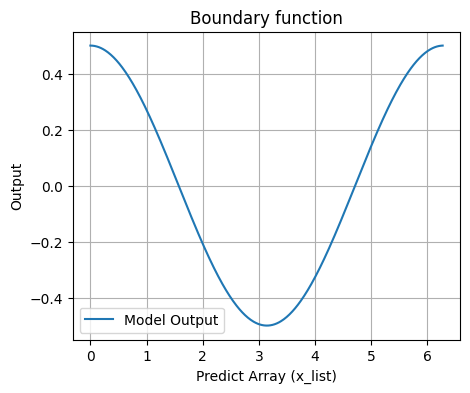

torch.Size([100, 500])
torch.Size([100, 500])
Forward pass time: 1.336737 seconds


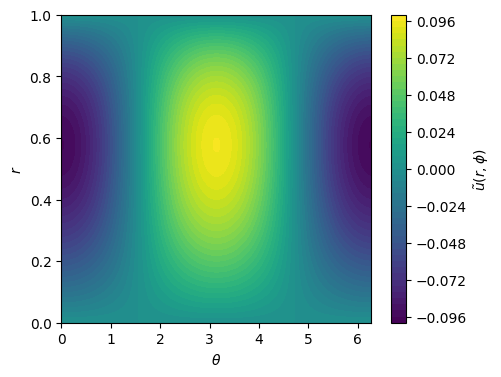

In [ ]:
# Potential Fredholm Neural Network class with precalculated integral using parallelized dblquad
# In this Poisson example we only need to pass the integral fundamental*source for (r_o, theta_o) that will be added to the bias term

K = 100
phi_grid_dict = {}
for i in range(0, K + 1):
    phi_0 = 0.0
    phi_n = 2.0 * np.pi
    phi_steps = 500
    dphi = (phi_n - phi_0) / phi_steps
    phi = np.arange(phi_0, phi_n, dphi)
    phi_grid_dict[f'layer_{i}'] = phi


r_out = np.linspace(0, 1, 100)
theta_out = phi
theta_out_torch = torch.tensor(theta_out, dtype=torch.float32)

t0 = time.time()

# Precompute integrals for the output values
precomputed_integrals = parallel_integrate_meshgrid(r_out, theta_out)
precomputed_integrals_BIE = precomputed_integrals[-1,:]

# Convert results to tensor and map them to phi grid for quick lookup
precomputed_integral_map = {value: integral for value, integral in zip(theta_out, precomputed_integrals_BIE)}
t1 = time.time()
print(f"Integral time: {t1 - t0:.6f} seconds")

# Model parameters
input_size = len(theta_out)
output_size = len(theta_out)
km_constant = 0.3


t2 = time.time()

# Instantiate the Fredholm model
fredholm_model = FredholmNeuralNetwork_Poisson(
    phi_grid_dict, kernel, dphi, K, input_size, output_size, km_constant,
    func_fn, precomputed_integral_map)

# Instantiate the LimitInformed model with the precomputed integral for r_out == 1
limit_informed_model = PotentialFredholmNeuralNetwork_Poisson(
    fredholm_model=fredholm_model,
    diff_potentials_fn=diff_potentials_limit,
    potential_boundary_fn=potential_boundary,
    precomputed_integral_out=precomputed_integrals,
    plot_BIF=True)

# Forward pass
output = limit_informed_model(
    input=theta_out_torch,
    r_out=r_out,
    theta_out=theta_out,
    phi_grid=phi,
    grid_step=dphi
)

t3 = time.time()
print(f"Forward pass time: {t3 - t2:.6f} seconds")

# Extract data for visualization
data = output.detach().numpy()[:, :, 0]

# Contour plot for visualization in (r, theta) space
R_out, Theta_out = np.meshgrid(r_out, theta_out, indexing='ij')
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, data, levels=50, cmap='viridis')
cbar = plt.colorbar()
# cbar.ax.tick_params(l)
cbar.set_label(r"$\tilde{u}(r,\phi)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$r$")
plt.tick_params(axis='both')
plt.show()

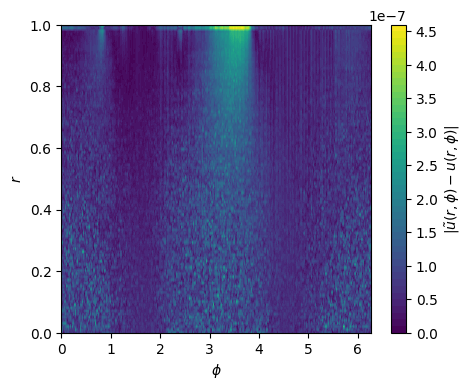

In [ ]:
# Calculate and plot absolute error compared to the true solution

# True solution
def laplace_solution_cartesian(x, y):
    return (1/4)*(x**2 + y**2 -1)*x

# Function to compute the Laplace solution in polar coordinates
def laplace_solution_polar(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return laplace_solution_cartesian(x, y)


# Create the contour plot for the absolute error
difference = np.abs(data - laplace_solution_polar(R_out, Theta_out))
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, difference, levels=50, cmap='viridis')
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks
cbar.set_label(r"$|\tilde{u}(r,\phi) - u(r,\phi)|$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
plt.tick_params(axis='both')
plt.show()